#  mlflow Demonstration 1

This notebook illustrates mlflow's capabilities to track model training results.  This demonstration is based on the [mlflow scikit-learn ElaticNet example](https://github.com/mlflow/mlflow/tree/master/examples/sklearn_elasticnet_wine)

In [1]:
from __future__ import print_function

In [2]:
import yaml
import os.path
import socket
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet

import mlflow
import mlflow.sklearn
import mlflow.tracking


## Set up training and test data sets

In [3]:
#%%
# Read the wine-qualiaty csv file (make sure you're running this from the root of MLflow!)
data = pd.read_csv("./wine-quality.csv")

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data,random_state=13)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

## Setup mlflow for tracking model training results 

In [4]:
host_name = "mlflow_server" #socket.gethostname()
BASE_URL = 'http://' + host_name +':5000'

mlflow.set_tracking_uri(BASE_URL)
mlflow.get_tracking_uri()

'http://mlflow_server:5000'

## Setup up mlflow experiment

In [5]:
#%%
experiment_id = mlflow.create_experiment('mlflow_demo1')

# work-around for issue with recording first run of an experiment Issue #852
with mlflow.start_run(experiment_id=experiment_id):
    pass

## Run sklearn hyper-parameter optmization using randomized cross-validation search

In [6]:
# hyper-parameter specificaitons into runable form
runable_hyper_parameters = {'alpha': scipy.stats.uniform(0,1), 
                            'l1_ratio': scipy.stats.uniform(0,1),
                           'random_state': [13]}

this_model = ElasticNet(random_state=13)

randomized_search_cv = RandomizedSearchCV(this_model,
                                          param_distributions = runable_hyper_parameters,
                                          n_iter=20,
                                          cv=5,
                                          n_jobs=-1,
                                          scoring='r2',
                                          random_state=13,
                                          verbose=1)
randomized_search_cv.fit(train_x,train_y.quality)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=13, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff1f23080>, 'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff1f23588>, 'random_state': [13]},
          pre_dispatch='2*n_jobs', random_state=13, refit=True,
          return_train_score='warn', scoring='r2', verbose=1)

## Record model training results to mlflow

### save raw data used in training to mlflow

In [7]:
# log training data
mlflow.log_artifact('./wine-quality.csv','raw_data')

### save optimal hyper-parameter values to mflow

In [8]:
for k in randomized_search_cv.best_params_.keys():
    mlflow.log_param(k,randomized_search_cv.best_params_[k])

### save optimal model to mlflow

In [9]:
mlflow.sklearn.log_model(randomized_search_cv.best_estimator_,'best_estimator')

### record model metric of best model on test data set

In [10]:
# default score for ElasticNet is 'r2'
test_score = randomized_search_cv.best_estimator_.score(test_x,test_y.quality)
mlflow.log_metric('r2',test_score)

### save estimator type as user specified mlflow tag

In [11]:
mlflow.set_tag('estimator','from sklearn.linear_model import ElasticNet')

## Signal end of mlflow run

In [12]:
mlflow.end_run()

print("All DONE")

All DONE


## Screenshots of mflow browser tracking ui for `mlflow_demo1`


### _mlflow Experiment Overview page shows summary of available experiment results_ 

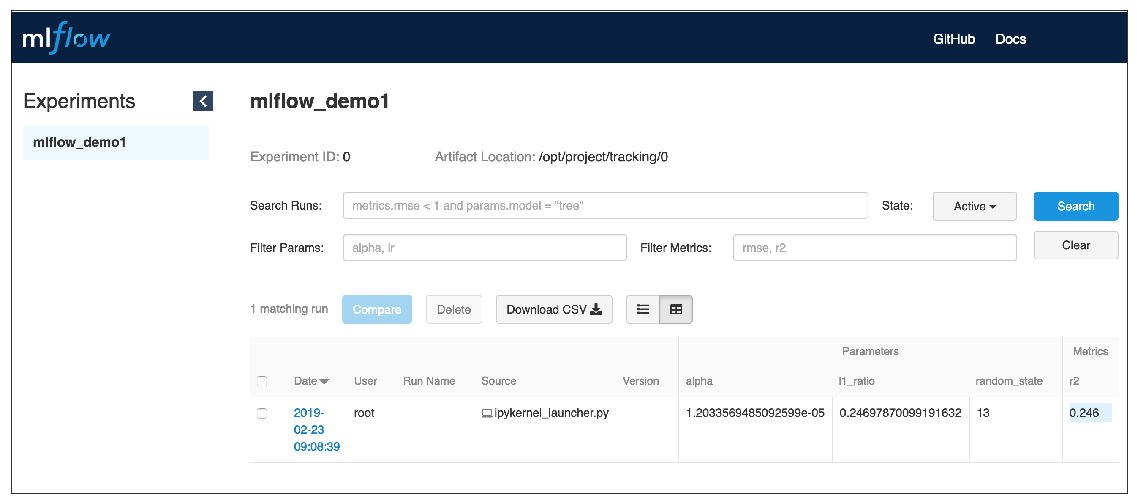

In [13]:
fig = plt.figure(figsize=(20,10))
img = plt.imread('./images/experiment_overview.png')
plt.xticks([])
plt.yticks([])
plt.imshow(img,figure=fig)

### _mlflow Run detail page shows details to a specific run within an experiment_

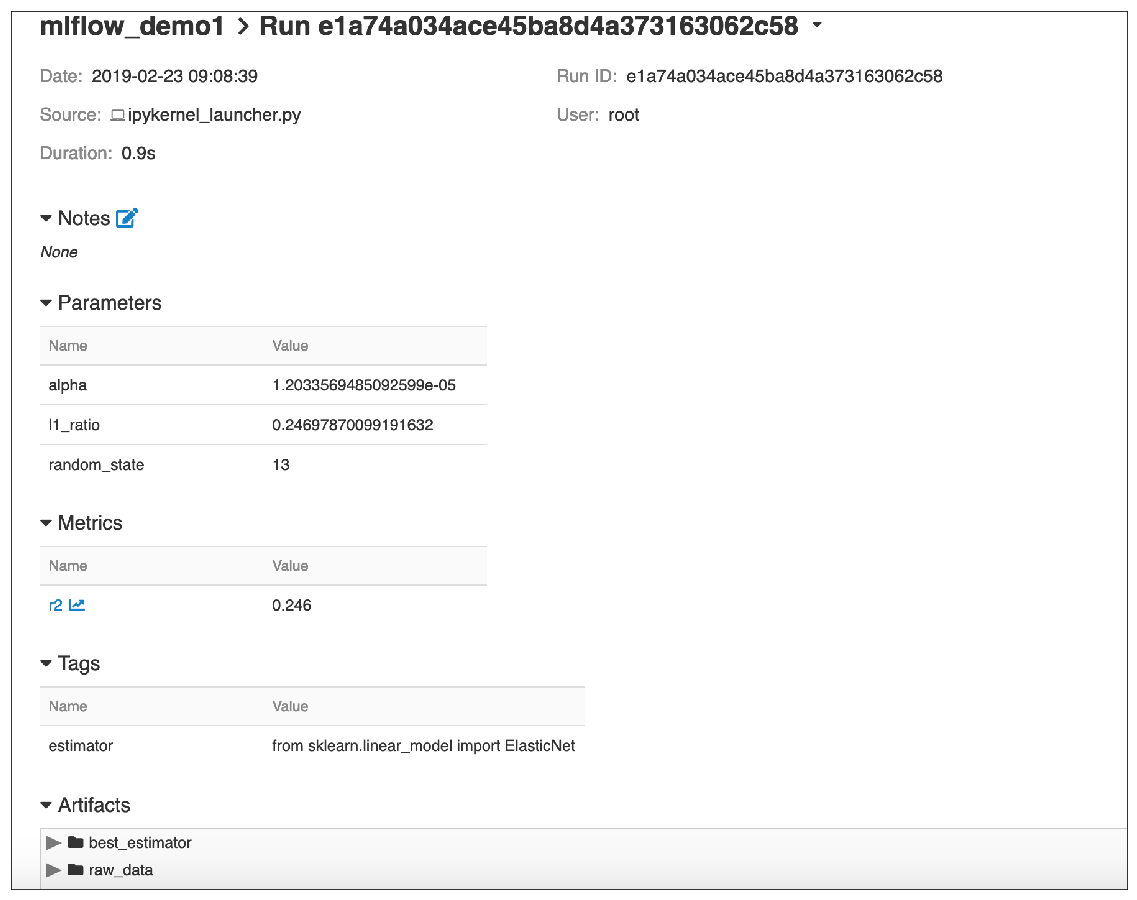

In [14]:
fig = plt.figure(figsize=(20,20))
img = plt.imread('./images/run_detail.png')
plt.xticks([])
plt.yticks([])
plt.imshow(img,figure=fig)

### _mlflow Run artfifacts shows the details for saved artifacts of a run_

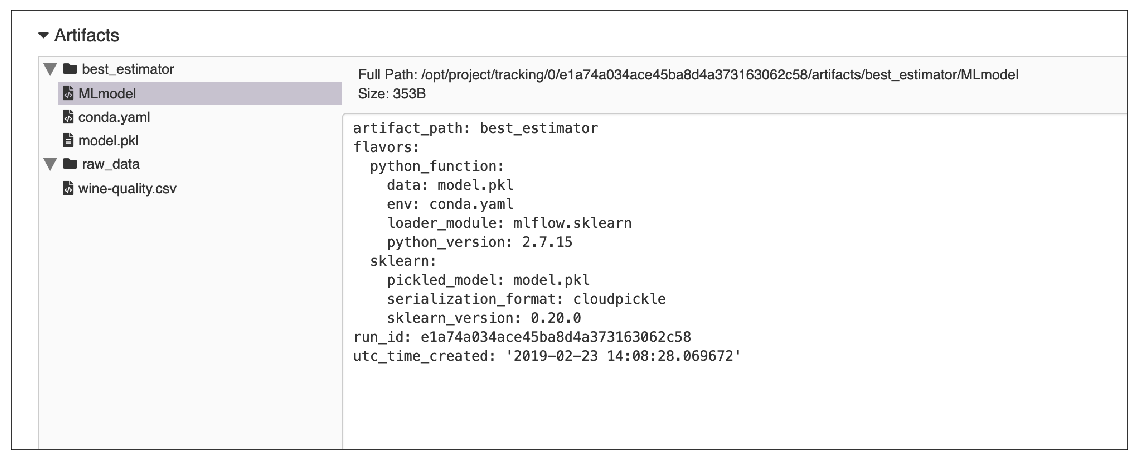

In [15]:
fig = plt.figure(figsize=(20,20))
img = plt.imread('./images/artifacts_detail.png')
plt.xticks([])
plt.yticks([])
plt.imshow(img,figure=fig)